# Bayesian Linear Regression

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import pystan

In [2]:
# reading annual data
data = pd.read_excel('Returns_handbook_data.xls', 'Monthly')
data.head()

,Date (yyyymm),S&P 500 index,12-month moving sum of S&P 500 dividends,12-month moving sum of S&P 500 earnings,DJIA book-to-market value ratio,3-month Treasury bill yield (secondary market),Moodys AAA-rated corporate bond yield,Moodys BAA-rated corporate bond yield,Long-term government bond yield,Net equity expansion,Risk-free rate,CPI (all urban consumers) inflation rate,Long-term government bond return,Long-term corporate bond return,Monthly sum of squared daily returns on S&P 500 index,CRSP S&P 500 value-weighted return with dividends,CRSP S&P 500 value-weighted return excluding dividends,NBER recession dummies,NBER recession dummies with peak included
0,187101.0,4.44,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,187102.0,4.50,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187103.0,4.61,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,187104.0,4.74,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.004632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,187105.0,4.86,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,0.003691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# List of variables
# d12 -> dividend yeild
# e12 -> earning price ration 
# b/m => book to market
# tbl => Treasury bill rate  = -0.004 + 0.886 * Compercial paper rate
# default yield stpread = (AAA - BAA)
# lty => Long-term government bond yield
# ntis => net equity expansion 
# rfree => risk free rate
# infl => inflation
# ltr => long-term return
# corpr => corporate bond returns
# svar => stock variance
# csp => Cross sectional premiums 
# CRSP_SPww =>
# CRSP_SPvwx =>  
# tms => long term yield - trea

In [3]:
print('All column names')
print('--'*20)
for idx in range(len(data.columns)):
    print(idx, '--', string.ascii_lowercase[idx], '--', data.columns[idx])

All column names
----------------------------------------
0 -- a -- Date (yyyymm)
1 -- b -- S&P 500 index
2 -- c -- 12-month moving sum of S&P 500 dividends
3 -- d -- 12-month moving sum of S&P 500 earnings
4 -- e -- DJIA book-to-market value ratio
5 -- f -- 3-month Treasury bill yield (secondary market)
6 -- g -- Moodys AAA-rated corporate bond yield
7 -- h -- Moodys BAA-rated corporate bond yield
8 -- i -- Long-term government bond yield
9 -- j -- Net equity expansion
10 -- k -- Risk-free rate
11 -- l -- CPI (all urban consumers) inflation rate
12 -- m -- Long-term government bond return
13 -- n -- Long-term corporate bond return
14 -- o -- Monthly sum of squared daily returns on S&P 500 index
15 -- p -- CRSP S&P 500 value-weighted return with dividends
16 -- q -- CRSP S&P 500 value-weighted return excluding dividends
17 -- r -- NBER recession dummies
18 -- s -- NBER recession dummies with peak included


In [4]:
print('Shape of dataset:', data.shape)

Shape of dataset: (1682, 19)


In [0]:
# Equity premium

idx_first = 671 # starting data 1926:11
idx_last = 1679 # final date 2010:12

market_return = np.array(data.loc[idx_first:idx_last, ['CRSP S&P 500 value-weighted return with dividends']]).flatten()
r_f_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'Risk-free rate']) # risk free rate
equity_premium = np.log(1+market_return)-np.log(1+r_f_lag) # log excess return

In [0]:
#dividends
d12=np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 dividends']) 
#S7P 500 index
sp500 = np.array(data.loc[idx_first:idx_last, 'S&P 500 index']) 
# log dividend-price ratio
dp = np.log(d12) - np.log(sp500) 
# S&P 500 index, lagged 
sp500_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'S&P 500 index']) # S&P 500 index, lagged 
# log dividend yield
dy = np.log(d12) - np.log(sp500_lag)
# earnings
e12 = np.array(data.loc[idx_first:idx_last, '12-month moving sum of S&P 500 earnings'])
# log earnings to price ratio
ep = np.log(e12) - np.log(sp500)
# log dividend-payout ratio
de = np.log(d12) - np.log(e12)
# volatility (SVAR)
svar = np.array(data.loc[idx_first:idx_last, 'Monthly sum of squared daily returns on S&P 500 index'])
# book to market ratio
bm = np.array(data.loc[idx_first:idx_last, 'DJIA book-to-market value ratio'])
# net equity issuing activity
ntis=np.array(data.loc[idx_first:idx_last, 'Net equity expansion'])
# t-bill raate
tbl = np.array(data.loc[idx_first:idx_last, '3-month Treasury bill yield (secondary market)'])
# long-term government bond yield
lty = np.array(data.loc[idx_first:idx_last, 'Long-term government bond yield'])
# long-term governmnent bond return
ltr = np.array(data.loc[idx_first:idx_last, 'Long-term government bond return'])
# term spread
tms=lty-tbl

# AAA-rated corporate bond yield
aaa = np.array(data.loc[idx_first:idx_last, 'Moodys AAA-rated corporate bond yield'])

# BAA-rated corporate bond yield
baa = np.array(data.loc[idx_first:idx_last, 'Moodys BAA-rated corporate bond yield'])

# Default yield spread
dfy = baa-aaa

# Long-term corporate bond return
corpr = np.array(data.loc[idx_first:idx_last, 'Long-term corporate bond return'])

# Default return spread
dfr = corpr - ltr

# Inflation, lagged(1926:11-2010:11)
infl_lag = np.array(data.loc[(idx_first-1):(idx_last-1), 'CPI (all urban consumers) inflation rate'])

In [0]:
# Sum of the parts variables

# earnings lagged (1926:11-2010:11)
e12_lag = np.array(data.loc[(idx_first-1):idx_last-1, '12-month moving sum of S&P 500 earnings'])
# earnings growth
e_growth = np.log((1/12)*e12) - np.log((1/12)*e12_lag) # earnings growth
# log (1+D/P)
dp_sop = np.log(1+(1/12)*(d12/sp500)) # log(1+D/P)
# risk-free rate
r_f = np.array(data.loc[idx_first:idx_last, 'Risk-free rate'])
# log risk free rate
r_f = np.log(1 + r_f)

## Linear model in Stan

In [20]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time

stan_code = """
data {
    int<lower=0> n_data;     // Number of data points
    int<lower=0> n_var;       // Number of predictor variables
    matrix[n_data, n_var] X;    // data matrix
    real r[n_data + 1];            // log-returns
    int<lower=0> n_out_sample;  // The out of sample cut off point
    int<lower=0> n_preds;       // Number of predictions to generate
    real beta_mean;  // The mean hyperparameter for prior of betas
    real beta_std;  // The std hyperparameter for prior of betas
    real sigma_mean;    // The mean hyperparameter for prior of sigma
    real sigma_std;     // The std hyperparameter for prior of sigma
}

parameters {

    vector[n_var] beta;
    real sigma;
}

transformed parameters {
    // transformed parameters
}

model {

    beta ~ normal(beta_mean, beta_std);
    sigma ~ normal(sigma_mean, sigma_std);

    for (i in 1:n_out_sample) {
        r[i+1] ~ normal(dot_product(beta, X[i]), sigma);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real y_pred[n_preds];

    for(t in 1:n_preds) {
        y_pred[t] = normal_rng(
            dot_product(beta, X[t + n_out_sample]),
            sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b5c9597024224ab580fb11622f2dbf06 NOW.


In [26]:
R = (1946-1926)*12+1 # In-sample period from 1926:12-1946:12
P_0 = (1956-1946)*12 # holdout out-of-sample period, 1947:01 - 1956:12
n_out_sample = (R + P_0) - 1
n_preds = len(equity_premium) - n_out_sample -1

X = np.column_stack((np.ones(len(dp)), dp, dy, ep, de, svar, bm, ntis, tbl, lty, ltr, tms, dfy, dfr, infl_lag))

stan_data = {
    'n_data': X[:-1].shape[0],
    'n_var': X[:-1].shape[1],
    'X': X[:-1],
    'r': equity_premium,
    'n_preds': n_preds,
    'n_out_sample': n_out_sample,
    'beta_mean': 0,
    'beta_std': 1,
    'sigma_mean': 0,
    'sigma_std': 1
} 

parameters = ['beta', 'sigma']
results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_b5c9597024224ab580fb11622f2dbf06.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1]   -0.21  3.9e-3   0.09  -0.39  -0.27  -0.21  -0.14  -0.02    536   1.01
beta[2]    -0.1    0.03   0.56  -1.19  -0.49   -0.1   0.28   0.97    316   1.01
beta[3]     0.1  1.8e-3   0.05  -0.01   0.06    0.1   0.13    0.2    881   1.01
beta[4]   -0.04    0.03   0.56  -1.12  -0.42  -0.04   0.36   1.05    316   1.01
beta[5]    -0.1    0.03   0.56  -1.19  -0.48   -0.1    0.3   0.99    317   1.01
beta[6]    0.16    0.02   0.63  -1.06  -0.27   0.16   0.59   1.42    968    1.0
beta[7]     0.1  1.4e-3   0.03   0.04   0.08    0.1   0.12   0.17    555    1.0
beta[8]    0.08  6.9e-3   0.18  -0.27  -0.05   0.08    0.2   0.44    703    1.0
beta[9]    0.16    0.03   0.65  -1.15  -0.29   0.16   0.61   1.44    421   1.01
beta[10]  -

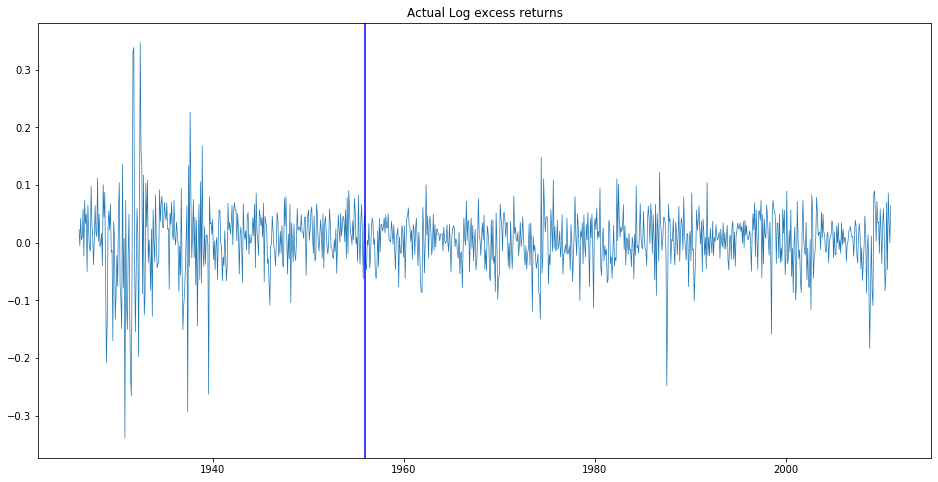

In [22]:
years = np.linspace(1926, 2011, X.shape[0])
plt.figure(figsize=(16, 8))
plt.plot(years, equity_premium, lw=0.7)
plt.axvline(x=1926+(n_out_sample/12), color='b', label='Out-of-sample cutoff')
plt.title('Actual Log excess returns')
plt.show()

In [0]:
X_observed = np.linspace(1926, 1926+(n_out_sample/12), n_out_sample)
X_predicted = np.linspace(1926+(n_out_sample/12), 2011, n_preds)

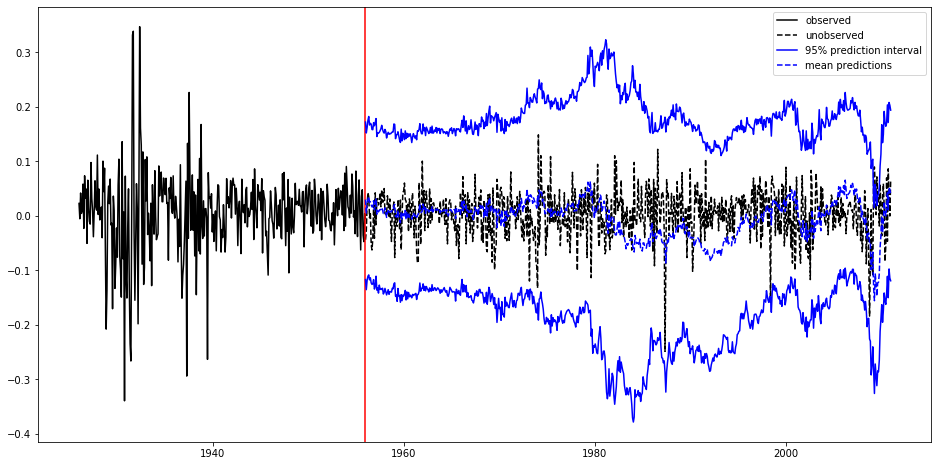

In [24]:
# Plot predictions
predictions = samples['y_pred']

# Compute 95% interval and median of the predicted values
prediction_interval = np.percentile(predictions, axis=0, q=[2.5, 97.5])

prediction_mean = np.mean(predictions, axis=0)

# Plot median samples
plt.figure(figsize=(16, 8))

X_observed = np.linspace(1926, 1926+(n_out_sample/12), n_out_sample)
X_predicted = np.linspace(1926+(n_out_sample/12), 2011, n_preds)
plt.plot(X_observed, equity_premium[:n_out_sample], 'k-', label='observed')
plt.plot(X_predicted, equity_premium[(n_out_sample+1):], 'k--', label='unobserved')
plt.axvline(x=1926+(n_out_sample/12), color='r')

plt.plot(X_predicted, prediction_interval[0, :], 'b-', label='95% prediction interval')
plt.plot(X_predicted, prediction_interval[1, :], 'b-')

plt.plot(X_predicted, prediction_mean, 'b--', label='mean predictions')
plt.legend()
plt.show()

### Estimating $R^2_{OS}$

$$MSFE_i = \frac{1}{n_2} \sum_{s=1}^{n_2}(r_{n_1+s}-\hat{r}_{i, n_1+s})^2$$
where, $\hat{r}$ is the prediction.

$$MSFE_o = \frac{1}{n_2} \sum_{s=1}^{n_2}(r_{n_1+s}-\overline{r}_{n_1+s})^2$$
where, $\overline{r_{t+1}}=\frac{1}{t}\sum_{s=1}^{t}r_t$

Then, 
$$R^2_{OS} = 1 - (MSFE_i / MSFE_0)$$

In [25]:
def calc_msfe(y_actual, y_predictions):
    n = len(y_actual)
    errors = [(y_actual[i]-y_predictions[i])**2 for i in range(n)]
    return np.sum(errors)/n

def calc_historical_return(returns):
    return [(np.sum(returns[:t])/t) for t in range(1, len(returns))]

def calc_r2_os(y_actual, y_predictions):
    msfe_i = calc_msfe(y_actual[1:], y_predictions)
    msfe_0 = calc_msfe(y_actual[1:], calc_historical_return(y_actual))

    return 1 - (msfe_i / msfe_0)

print('R2OS is ', calc_r2_os(equity_premium[n_out_sample:], prediction_interval[1, :]))

R2OS is  -17.473873551728282
